# Census Income Project
Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

Description of fnlwgt (final weight) The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score,recall_score,precision_score,f1_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the data set
df = pd.read_csv(r'https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')
#print first 5 rows of the dataset
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


# Understanding the Dataset

In [3]:
df.shape

(32560, 15)

In [4]:
df.duplicated().sum()

24

In [5]:
#checking null values in dataset
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [6]:
#checing datatypes of each column
df.dtypes.sort_values(ascending=False)

Workclass         object
Education         object
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Native_country    object
Income            object
Age                int64
Fnlwgt             int64
Education_num      int64
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
dtype: object

In [7]:
#Here Income is also considered as an Object Datatype, and hence we shall convert that into int as well.

In [8]:
#let's explore the value counts of each feature
for i in df.columns:
    print("*******************************************************")
    print("Value counts of", i, "\n" )
    print(df[i].value_counts())
    print('*******************************************************')

*******************************************************
Value counts of Age 

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: Age, Length: 73, dtype: int64
*******************************************************
*******************************************************
Value counts of Workclass 

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
*******************************************************
*******************************************************
Value counts of Fnlwgt 

164190    13
203488    13
123011    13
148995    12
126675    12
          ..
325573     1
140176     1
318264     1
329205     1
257302     1
Name: Fnlwgt, Length: 21647, dtype: int64
*****************************************

# OBSERVATIONS

In [9]:
df = df.replace(' ?', np.NaN)
df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3769
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [10]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

In [11]:
df['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [12]:
df['Native_country'].value_counts()

 United-States                 29169
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 France                           29
 

# ENCODING

In [13]:
from sklearn.preprocessing import LabelEncoder
for col_name in df.columns:
    series = df[col_name]
    label_encoder = LabelEncoder()
    df[col_name] = pd.Series(
        label_encoder.fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    )

In [14]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

In [15]:
for i in df.columns:
    print("*******************************************************")
    print("Value counts of", i, "\n" )
    print(df[i].value_counts(dropna=False))
    print('*******************************************************')

*******************************************************
Value counts of Age 

19    898
14    888
17    886
6     877
18    876
     ... 
66      6
71      3
68      3
69      1
70      1
Name: Age, Length: 73, dtype: int64
*******************************************************
*******************************************************
Value counts of Workclass 

3.0    22696
5.0     2541
1.0     2093
NaN     1836
6.0     1297
4.0     1116
0.0      960
7.0       14
2.0        7
Name: Workclass, dtype: int64
*******************************************************
*******************************************************
Value counts of Fnlwgt 

8878     13
13073    13
5813     13
7676     12
6094     12
         ..
19008     1
7000      1
18803     1
19104     1
16527     1
Name: Fnlwgt, Length: 21647, dtype: int64
*******************************************************
*******************************************************
Value counts of Education 

11    10501
15     7291
9      5354
12

In [16]:
df.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

In [17]:
df = df.astype(np.uint8,errors='ignore')

# IMPUTATION

In [18]:
#Simple Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values= np.NaN, strategy='most_frequent')
df.Workclass = imputer.fit_transform(df['Workclass'].values.reshape(-1,1))[:,0] 

In [19]:
df.Occupation = imputer.fit_transform(df['Occupation'].values.reshape(-1,1))[:,0]

In [20]:
df.Native_country = imputer.fit_transform(df['Native_country'].values.reshape(-1,1))[:,0]

In [21]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

In [22]:
#lets check the statistical description of the each column
pd.set_option("display.max_rows", None, "display.max_columns", None)
df.describe(include='all')

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
count,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,21.580313,3.094349,127.627211,10.298249,9.080590,2.611794,6.138943,1.446376,3.665848,0.669195,6.500645,2.053348,39.377948,36.417107,0.240817
std,13.635711,1.107094,74.032147,3.870317,2.572709,1.506225,3.972623,1.606794,0.848817,0.470510,23.300419,10.056712,12.144192,6.056133,0.427586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,3.000000,64.000000,9.000000,8.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,39.000000,38.000000,0.000000
50%,20.000000,3.000000,128.000000,11.000000,9.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,39.000000,38.000000,0.000000
75%,31.000000,3.000000,192.000000,12.000000,11.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,44.000000,38.000000,0.000000
max,72.000000,7.000000,255.000000,15.000000,15.000000,6.000000,13.000000,5.000000,4.000000,1.000000,118.000000,91.000000,93.000000,40.000000,1.000000


0    24719
1     7841
Name: Income, dtype: int64


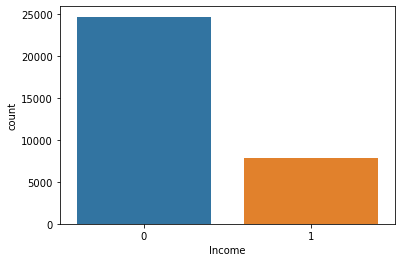

In [23]:
#count of each class (Attrition(1) = 237, NoAttrition(0)=1233)
ax=sns.countplot(x="Income", data=df)
print(df['Income'].value_counts())

<AxesSubplot:>

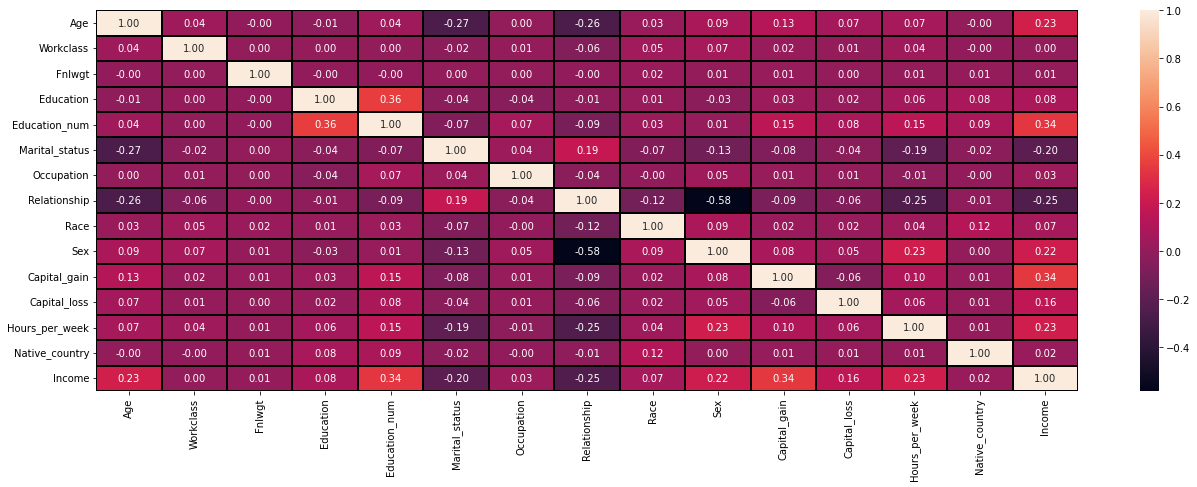

In [24]:
#Correlation using HEATMAP
import matplotlib.pyplot as plt
plt.figure(figsize=(22,7))
sns.heatmap(df.corr(),annot=True,linewidth=0.1,linecolor="black",fmt="0.2f")

In [25]:
#Correlation with the target column
corr_mat=np.abs(df.corr())
corr_mat['Income'].sort_values(ascending=False)

Income            1.000000
Capital_gain      0.340034
Education_num     0.335182
Relationship      0.250924
Age               0.234136
Hours_per_week    0.232394
Sex               0.215995
Marital_status    0.199295
Capital_loss      0.162511
Education         0.079311
Race              0.071853
Occupation        0.034599
Native_country    0.023063
Fnlwgt            0.005950
Workclass         0.002739
Name: Income, dtype: float64

# DIVIDE DATA INTO FEATURES & LABEL

In [26]:
#diving the columns in feature and label
X = df.drop(columns=['Income'])
y = df['Income']

# DATA VISUALIZATION

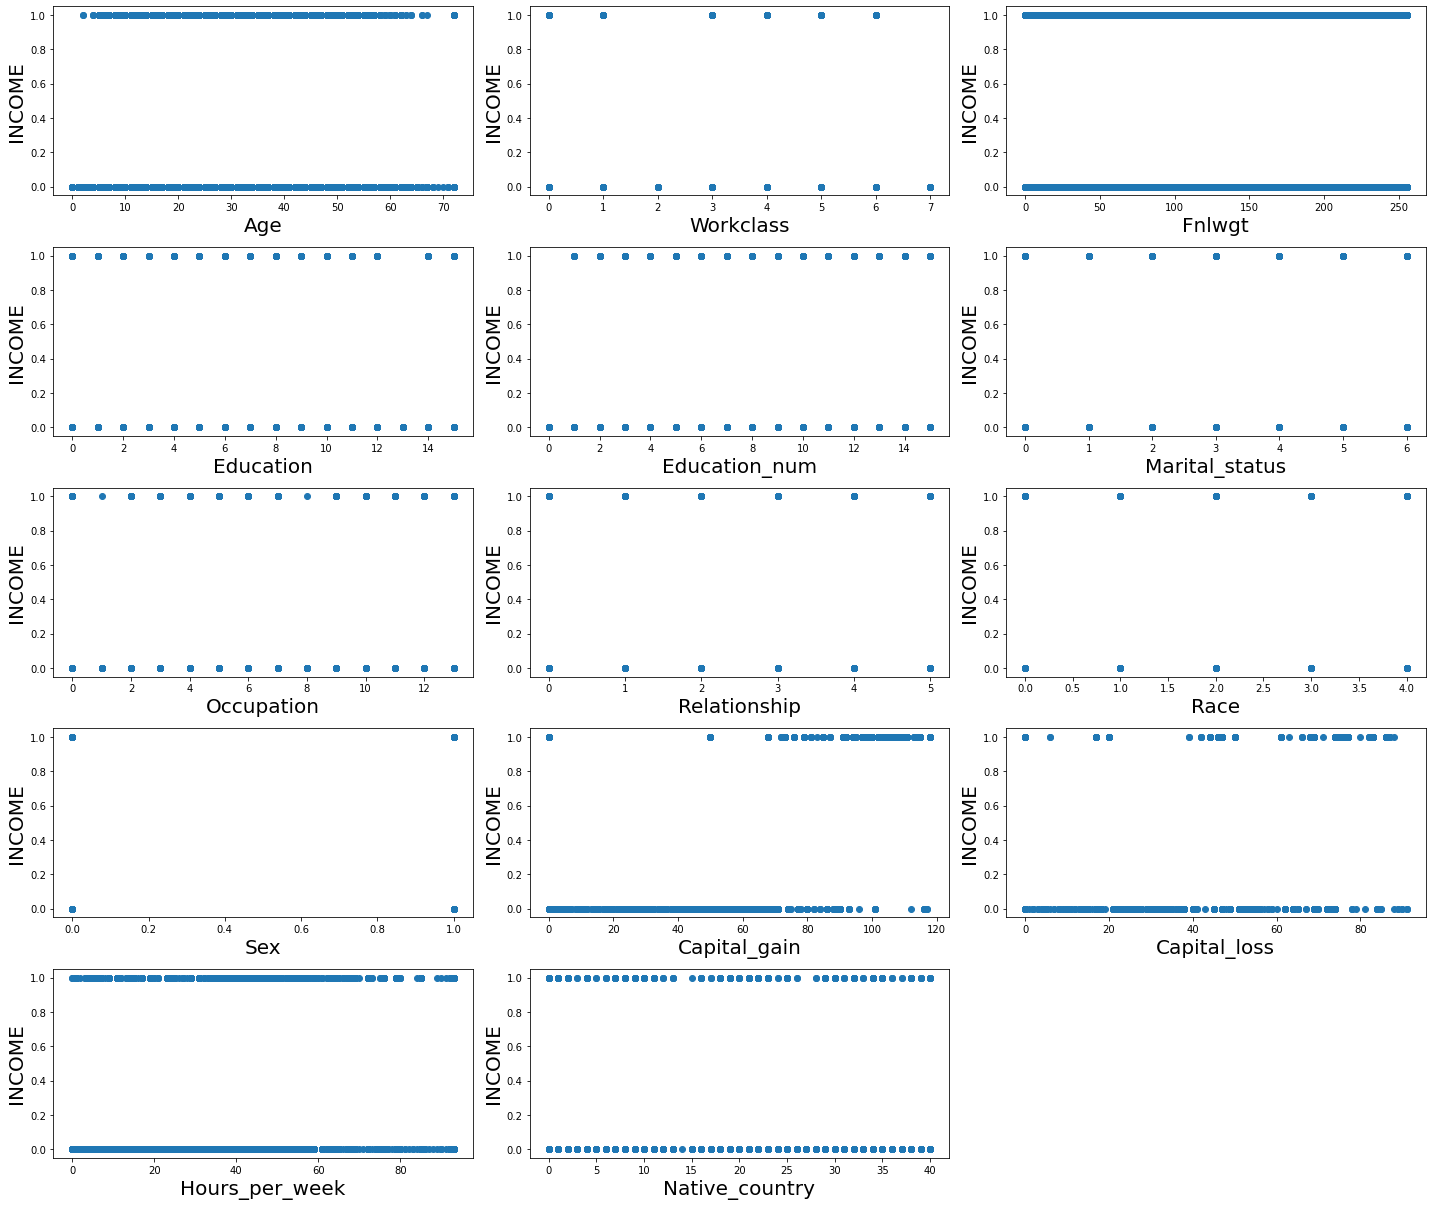

In [27]:
#Visualizing relatinship between feature and label (SCATTER PLOT)

plt.figure(figsize=(20,33),facecolor='white')
plotnumber=1

for column in X:
    if plotnumber<=30: 
        ax=plt.subplot(10,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('INCOME', fontsize=20)
    plotnumber+=1
plt.tight_layout()

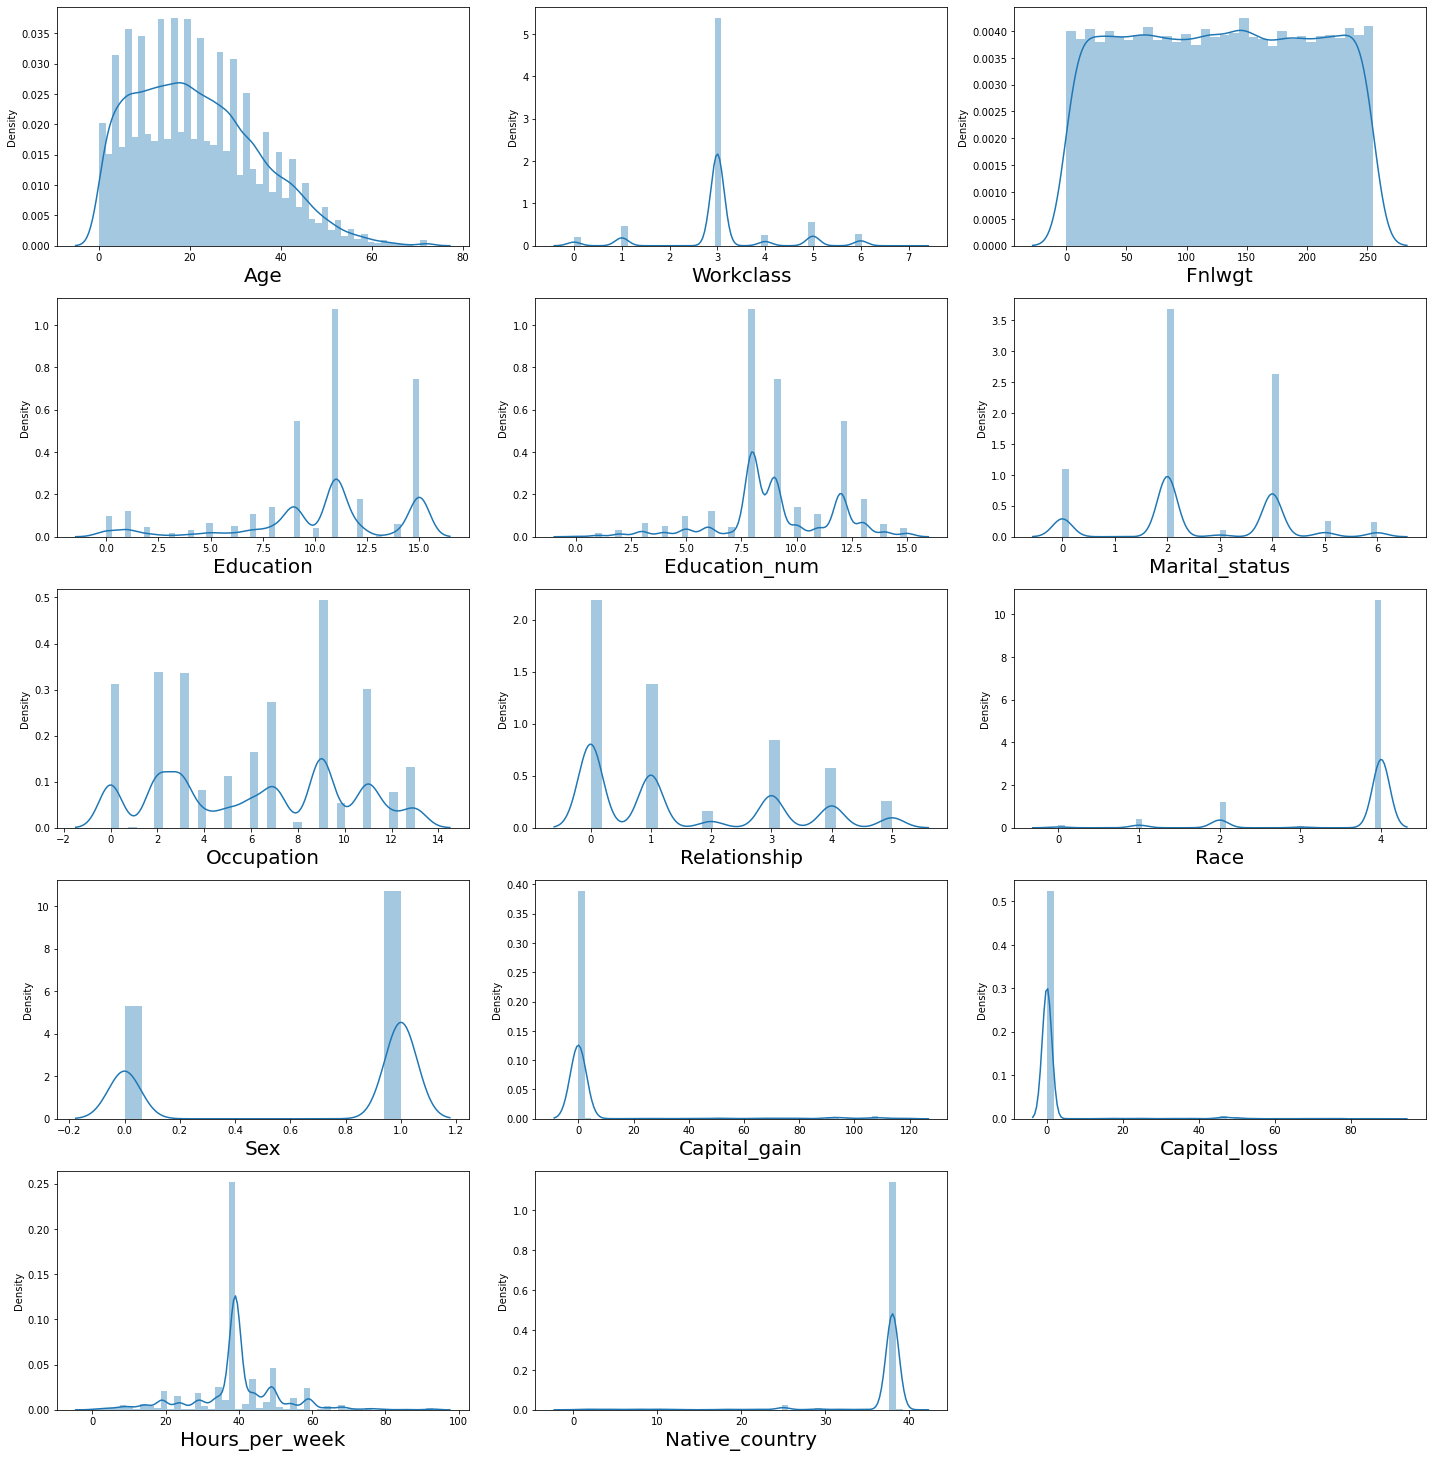

In [28]:
#Visualise the distribution of data in the feature columns(DISTRIBUTION PLOT)

plt.figure(figsize = (20,40), facecolor = 'white')
plotnumber = 1

for column in X:
    if plotnumber<=30:
        ax = plt.subplot(10,3,plotnumber)
        sns.distplot(X[column])
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.tight_layout()

In [29]:
#Checking skewness of the features
X.skew().sort_values(ascending=False)

Capital_loss      5.266058
Capital_gain      3.572186
Relationship      0.786784
Age               0.555583
Workclass         0.076178
Hours_per_week    0.069753
Occupation        0.000536
Fnlwgt            0.000464
Marital_status   -0.013448
Education_num    -0.311630
Sex              -0.719244
Education        -0.934063
Race             -2.435332
Native_country   -4.243083
dtype: float64

In [30]:
#We can see skewness in few of our columns, we will remove the skewness using power_transform function
from sklearn.preprocessing import power_transform
X_new = power_transform(X)
X=pd.DataFrame(X_new,columns=X.columns)
X.skew().sort_values(ascending=False) #validating that the skewness is removed

Capital_loss      4.299512
Capital_gain      3.017222
Workclass         0.216967
Hours_per_week    0.199586
Relationship      0.122917
Education_num     0.019545
Age              -0.104049
Marital_status   -0.114201
Occupation       -0.237163
Fnlwgt           -0.281773
Education        -0.309431
Sex              -0.719244
Race             -2.010817
Native_country   -2.981838
dtype: float64

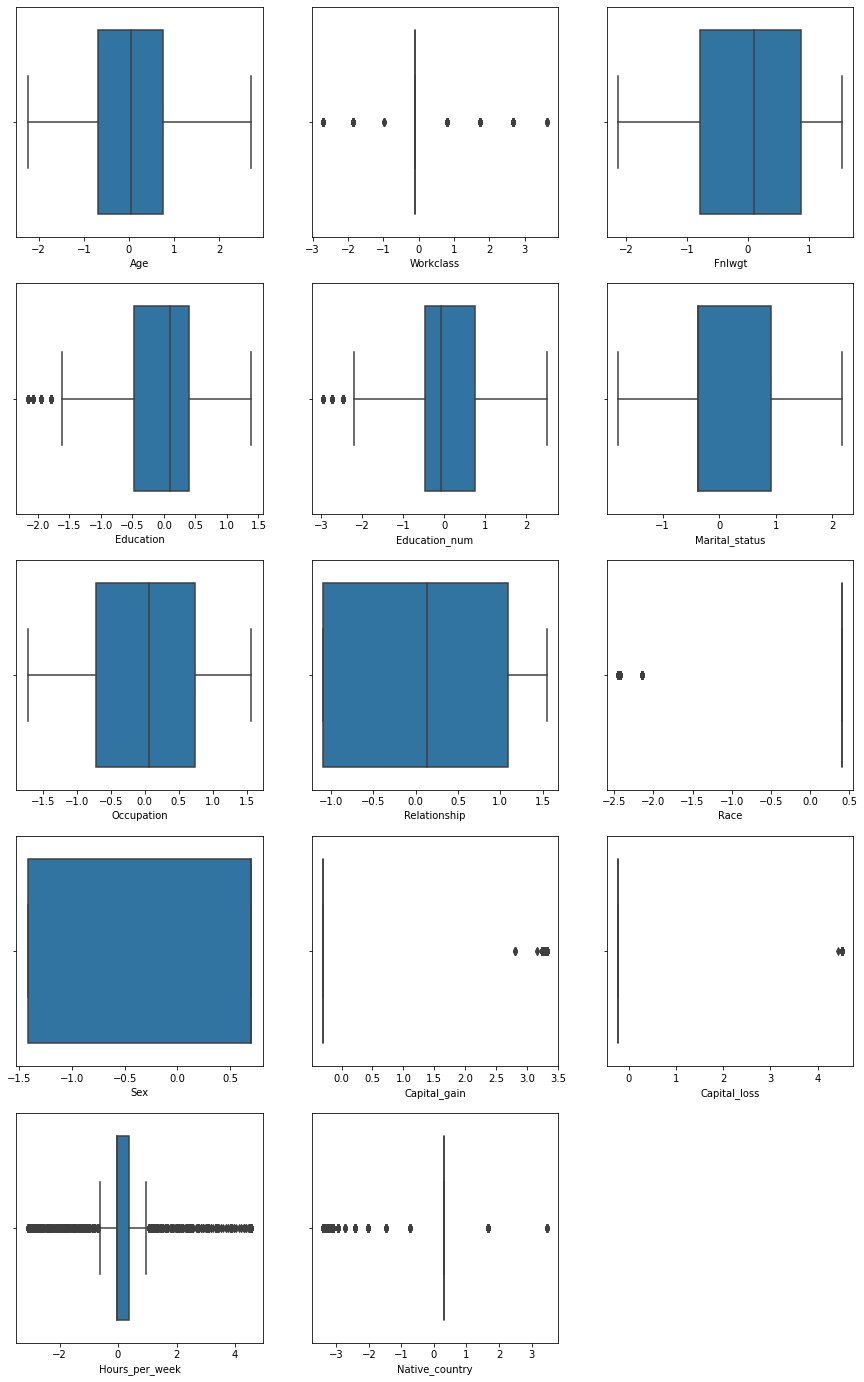

In [31]:
#Visualizing the outliers using BOXPLOT

plt.figure(figsize=(15,50))
graph=1

for column in X:
    if graph<=30: 
        ax=plt.subplot(10,3,graph)
        sns.boxplot(X[column],orient='v')
        plt.xlabel(column,fontsize=10)
    graph+=1
plt.show()

In [32]:
#Data Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
#Finding best random_state
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

maxAccu=0 #maximum accuracy
maxRS=0 #best random state value for which max accuracy is acheived 
for i in range(1,200):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf=LR.predict(x_test)
    acc=accuracy_score(y_test,predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is", maxAccu,"on Random State", maxRS)

Best accuracy is 0.8413697788697788 on Random State 109


In [34]:
#CREATING TRAIN-TEST SPLIT
x_train_imb, x_test, y_train_imb, y_test =  train_test_split(X, y, test_size=0.20, random_state=119)

In [35]:
print(x_train_imb.shape)
print(y_train_imb.shape)
print(x_test.shape)
print(y_test.shape)

(26048, 14)
(26048,)
(6512, 14)
(6512,)


# USING SMOTE FOR DOWN-SAMPLING

0    24719
1     7841
Name: Income, dtype: int64


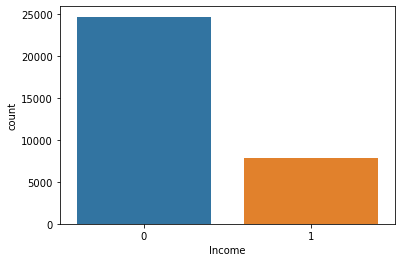

In [36]:
#count of each class (Attrition(1) = 237, NoAttrition(0)=1233)
ax=sns.countplot(x="Income", data=df)
print(df['Income'].value_counts())

In [37]:
print(y_train_imb.value_counts())

0    19796
1     6252
Name: Income, dtype: int64


In [38]:
!pip install imblearn

In [42]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
sm = RandomUnderSampler()
down_smp=RandomUnderSampler(0.99)
x_train_ns,y_train_ns=down_smp.fit_sample(x_train_imb,y_train_imb)
from collections import Counter
print('The no of samples before fit()', format(Counter(y_train_imb)))
print('The no of samples after fit()', format(Counter(y_train_ns)))
The no of samples before fit() Counter({0: 19700, 1: 6328})
The no of samples after fit() Counter({0: 6391, 1: 6328})

SyntaxError: invalid syntax (3228712656.py, line 9)

In [44]:
print(y_train.value_counts())

0    19776
1     6272
Name: Income, dtype: int64


In [46]:
# Using shallow copy or deep copy
import copy
x_train = copy.copy(x_train)
y_train = copy.copy(y_train)

In [47]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(26048, 14)
(26048,)
(6512, 14)
(6512,)


# APPLYING CLASSIFICATION MODELS & FINDING BEST FIT MODEL

In [48]:
results = pd.DataFrame()
model_name=[]
accuracy=[]
cvs=[]

In [49]:
#LOGISTIC REGRESSION
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred=LR.predict(x_test)
accuracy_LR = accuracy_score(y_test,y_pred)*100
scr = cross_val_score(LR,X,y,cv=5)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
model_name.append("Logistic Regression")
accuracy.append(accuracy_LR)
cvs.append(scr.mean())

[[4628  295]
 [ 828  761]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4923
           1       0.72      0.48      0.58      1589

    accuracy                           0.83      6512
   macro avg       0.78      0.71      0.73      6512
weighted avg       0.82      0.83      0.81      6512



In [50]:
#DECISION TREE CLASSIFIER
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
accuracy_dt = accuracy_score(y_test,y_pred_dt)*100
scr2 = cross_val_score(dt,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))
model_name.append("Decistion Tree Classifier")
accuracy.append(accuracy_dt)
cvs.append(scr2.mean())

[[4797  126]
 [ 118 1471]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4923
           1       0.92      0.93      0.92      1589

    accuracy                           0.96      6512
   macro avg       0.95      0.95      0.95      6512
weighted avg       0.96      0.96      0.96      6512



In [51]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
accuracy_rf = accuracy_score(y_test,y_pred_rf)*100
scr3 = cross_val_score(rf,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
model_name.append("Random Forest Classifier")
accuracy.append(accuracy_rf)
cvs.append(scr3.mean())

[[4855   68]
 [ 122 1467]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4923
           1       0.96      0.92      0.94      1589

    accuracy                           0.97      6512
   macro avg       0.97      0.95      0.96      6512
weighted avg       0.97      0.97      0.97      6512



In [52]:
#SVC
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
accuracy_svc = accuracy_score(y_test,y_pred_svc)*100
scr4 = cross_val_score(svc,X,y,cv=5)
print(confusion_matrix(y_test,y_pred_svc))
print(classification_report(y_test,y_pred_svc))
model_name.append("SVC")
accuracy.append(accuracy_svc)
cvs.append(scr4.mean())

[[4636  287]
 [ 740  849]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4923
           1       0.75      0.53      0.62      1589

    accuracy                           0.84      6512
   macro avg       0.80      0.74      0.76      6512
weighted avg       0.83      0.84      0.83      6512



In [53]:
results['Model Name'] = model_name
results['Accuracy'] = accuracy
results['Cross Value Score'] = cvs
results

,Model Name,Accuracy,Cross Value Score
0,Logistic Regression,82.754914,0.825123
1,Decistion Tree Classifier,96.253071,0.804515
2,Random Forest Classifier,97.082310,0.851628
3,SVC,84.229115,0.834828


In [54]:
#Let's tune the parameter using GridSearchCV
#RandomForestClassifier
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=41)
clf= RandomForestClassifier()
params = { 'n_estimators': [13,15],
          'criterion': ['entropy', 'gini'],
          'max_depth': [10,15],
          'min_samples_split':[10,11],
          'min_samples_leaf':[5,6]
         }
grid=GridSearchCV(clf,param_grid=params)
grid.fit(x_train,y_train)
print('best_params=>', grid.best_params_)
clf=grid.best_estimator_
clf.fit(x_train,y_train)
y_pred_gscv=clf.predict(x_test)
rf_conf_mat=confusion_matrix(y_test,y_pred_gscv)
print('\n Conf Mat =>''\n', rf_conf_mat)
print('\n' ' Accuracy rf Normal =>', accuracy_score(y_test,y_pred_gscv))

report = classification_report(y_test,y_pred_gscv)
print(report)

best_params=> {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 15}

 Conf Mat =>
 [[6995  431]
 [ 963 1379]]

 Accuracy rf Normal => 0.8572891072891073
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7426
           1       0.76      0.59      0.66      2342

    accuracy                           0.86      9768
   macro avg       0.82      0.77      0.79      9768
weighted avg       0.85      0.86      0.85      9768



# Concluding Remarks
Since Random Forest Regression model has the best score, we will finalise the model.

# SAVE THE MODEL

In [55]:
import joblib
joblib.dump(clf,'Census_Income_Project.obj')

['Census_Income_Project.obj']